### Import required packages and limit GPU usage

In [1]:
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import argparse
import time
import itertools
from copy import deepcopy
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

import networks
import utils
import biased_sampler
    
%load_ext autoreload
%autoreload 2

In [2]:
use_gpu = True    # set use_gpu to True if system has gpu
gpu_id = 1        # id of gpu to be used
cpu_device = torch.device('cpu')
# fast_device is where computation (training, inference) happens
fast_device = torch.device('cpu')
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '1,2'    # set visible devices depending on system configuration
    fast_device = torch.device('cuda:' + str(gpu_id))

In [3]:
# Ensure reproducibility
def reproducibilitySeed():
    """
    Ensure reproducibility of results; Seeds to 0
    """
    torch_init_seed = 0
    torch.manual_seed(torch_init_seed)
    numpy_init_seed = 0
    np.random.seed(numpy_init_seed)
    if use_gpu:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

reproducibilitySeed()

### Load dataset

In [4]:
import torchvision
import torchvision.transforms as transforms

# Student trained without data augmentation
transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5), (0.5, 0.5))
                ]
            )

train_val_dataset = torchvision.datasets.MNIST(root='./MNIST_dataset/', train=True, 
                                            download=True, transform=transform)

test_dataset = torchvision.datasets.MNIST(root='./MNIST_dataset/', train=False, 
                                            download=True, transform=transform)

num_train = int(1.0 * len(train_val_dataset) * 95 / 100)
num_val = len(train_val_dataset) - num_train
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [num_train, num_val])

In [5]:
batch_size = 128
num_class = 10
class_prob = [0.0 for _ in range(num_class)]
class_prob[7] = 0.5
class_prob[8] = 0.5

train_val_biased_sampler = biased_sampler.MNISTClassBiasedSampler(train_val_dataset, class_prob)
train_biased_sampler = biased_sampler.MNISTClassBiasedSampler(train_dataset, class_prob)

train_val_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=128, 
                                                sampler=train_val_biased_sampler, 
                                                num_workers=2)
train_val_balanced_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=128, shuffle=True, 
                                                        num_workers=2)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, 
                                            sampler=train_biased_sampler, 
                                            num_workers=2)
train_balanced_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True,
                                                    num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [6]:
checkpoints_path_teacher = 'checkpoints_teacher/'
checkpoints_path_student = 'checkpoints_student_biased_bf/'
summaries_path_student = 'summaries_student_biased_bf/'
if not os.path.exists(checkpoints_path_student):
    os.makedirs(checkpoints_path_student)
if not os.path.exists(summaries_path_student):
    os.makedirs(summaries_path_student)

### Load teacher network

In [7]:
# set the hparams used for training teacher to load the teacher network
learning_rates = [1e-2]
learning_rate_decays = [0.95]
weight_decays = [1e-5]
momentums = [0.9]
# keeping dropout input = dropout hidden
dropout_probabilities = [(0.0, 0.0)]
hparams_list = []
for hparam_tuple in itertools.product(dropout_probabilities, weight_decays, learning_rate_decays, 
                                        momentums, learning_rates):
    hparam = {}
    hparam['dropout_input'] = hparam_tuple[0][0]
    hparam['dropout_hidden'] = hparam_tuple[0][1]
    hparam['weight_decay'] = hparam_tuple[1]
    hparam['lr_decay'] = hparam_tuple[2]
    hparam['momentum'] = hparam_tuple[3]
    hparam['lr'] = hparam_tuple[4]
    hparams_list.append(hparam)
    
load_path = checkpoints_path_teacher + utils.hparamToString(hparams_list[0]) + '_final.tar'
teacher_net = networks.TeacherNetwork()
teacher_net.load_state_dict(torch.load(load_path, map_location=fast_device)['model_state_dict'])
teacher_net = teacher_net.to(fast_device)

In [8]:
# Calculate teacher test accuracy
_, test_accuracy = utils.getLossAccuracyOnDataset(teacher_net, test_loader, fast_device)
print('teacher test accuracy: ', test_accuracy)

teacher test accuracy:  0.9892


### Train student network without distillation

In [9]:
num_epochs = 20
num_epochs_bf = 20
print_every = 100

In [10]:
temperatures = [1]    # temperature for distillation loss
# trade-off between soft-target (st) cross-entropy and true-target (tt) cross-entropy;
# loss = alpha * st + (1 - alpha) * tt
alphas = [0.0]
learning_rates = [1e-2]
learning_rate_decays = [0.95]
weight_decays = [1e-5]
momentums = [0.9]
# No dropout used
dropout_probabilities = [(0.0, 0.0)]
hparams_list = []
for hparam_tuple in itertools.product(alphas, temperatures, dropout_probabilities, weight_decays, learning_rate_decays, 
                                        momentums, learning_rates):
    hparam = {}
    hparam['alpha'] = hparam_tuple[0]
    hparam['T'] = hparam_tuple[1]
    hparam['dropout_input'] = hparam_tuple[2][0]
    hparam['dropout_hidden'] = hparam_tuple[2][1]
    hparam['weight_decay'] = hparam_tuple[3]
    hparam['lr_decay'] = hparam_tuple[4]
    hparam['momentum'] = hparam_tuple[5]
    hparam['lr'] = hparam_tuple[6]
    hparams_list.append(hparam)

results_no_distill = {}
for hparam in hparams_list:
    print('Training with hparams' + utils.hparamToString(hparam))
    reproducibilitySeed()
    student_net = networks.StudentNetwork()
    student_net = student_net.to(fast_device)
    hparam_tuple = utils.hparamDictToTuple(hparam)
    results_no_distill[hparam_tuple] = [None, None]
    results_no_distill[hparam_tuple][0] = utils.trainStudentOnHparam(teacher_net, student_net, hparam, num_epochs, 
                                                                    train_loader, val_loader, 
                                                                    print_every=print_every, 
                                                                    fast_device=fast_device)
    results_no_distill[hparam_tuple][1] = utils.trainStudentOnHparam(teacher_net, student_net, hparam, num_epochs_bf, 
                                                                    train_balanced_loader, val_loader, 
                                                                    print_every=print_every, 
                                                                    fast_device=fast_device, 
                                                                    only_penultimate_train=True)
    save_path = checkpoints_path_student + utils.hparamToString(hparam) + '.tar'
    torch.save({'results' : results_no_distill[hparam_tuple], 
                'model_state_dict' : student_net.state_dict(), 
                'epoch' : num_epochs}, save_path)

Training with hparamsT=1, alpha=0.0, dropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=1e-05
epoch: 0 validation accuracy: 0.100
[1,   100/  446] train loss: 0.029 train accuracy: 0.992
[1,   200/  446] train loss: 0.017 train accuracy: 1.000
[1,   300/  446] train loss: 0.039 train accuracy: 0.984
[1,   400/  446] train loss: 0.006 train accuracy: 1.000
epoch: 1 validation accuracy: 0.197
[2,   100/  446] train loss: 0.005 train accuracy: 1.000
[2,   200/  446] train loss: 0.005 train accuracy: 1.000
[2,   300/  446] train loss: 0.019 train accuracy: 0.992
[2,   400/  446] train loss: 0.015 train accuracy: 0.992
epoch: 2 validation accuracy: 0.197
[3,   100/  446] train loss: 0.007 train accuracy: 1.000
[3,   200/  446] train loss: 0.004 train accuracy: 1.000
[3,   300/  446] train loss: 0.017 train accuracy: 0.992
[3,   400/  446] train loss: 0.029 train accuracy: 0.992
epoch: 3 validation accuracy: 0.197
[4,   100/  446] train loss: 0.025 trai

[11,   200/  446] train loss: 0.213 train accuracy: 0.945
[11,   300/  446] train loss: 0.310 train accuracy: 0.891
[11,   400/  446] train loss: 0.361 train accuracy: 0.898
epoch: 11 validation accuracy: 0.909
[12,   100/  446] train loss: 0.241 train accuracy: 0.945
[12,   200/  446] train loss: 0.230 train accuracy: 0.930
[12,   300/  446] train loss: 0.323 train accuracy: 0.906
[12,   400/  446] train loss: 0.217 train accuracy: 0.938
epoch: 12 validation accuracy: 0.912
[13,   100/  446] train loss: 0.342 train accuracy: 0.898
[13,   200/  446] train loss: 0.321 train accuracy: 0.891
[13,   300/  446] train loss: 0.264 train accuracy: 0.930
[13,   400/  446] train loss: 0.341 train accuracy: 0.906
epoch: 13 validation accuracy: 0.912
[14,   100/  446] train loss: 0.398 train accuracy: 0.867
[14,   200/  446] train loss: 0.223 train accuracy: 0.914
[14,   300/  446] train loss: 0.358 train accuracy: 0.859
[14,   400/  446] train loss: 0.276 train accuracy: 0.906
epoch: 14 validatio

T=1, alpha=0.0, dropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=1e-05


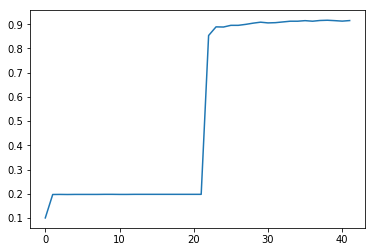

In [12]:
# plot validation accuracy 
for hparam in hparams_list:
    print(utils.hparamToString(hparam))
    hparam_tuple = utils.hparamDictToTuple(hparam)
    val_acc = results_no_distill[hparam_tuple][0]['val_acc'] + results_no_distill[hparam_tuple][1]['val_acc']
    plt.plot(val_acc)
    plt.show()

In [13]:
for hparam in hparams_list:
    load_path = checkpoints_path_student + utils.hparamToString(hparam) + '.tar'
    load_dict = torch.load(load_path)
    student_net = networks.StudentNetwork()
    student_net.load_state_dict(load_dict['model_state_dict'])
    student_net = student_net.to(fast_device)
    _, test_accuracy = utils.getLossAccuracyOnDataset(student_net, test_loader, fast_device)
    print(utils.hparamToString(hparam))
    print('test accuracy: ', test_accuracy)
    print('')

T=1, alpha=0.0, dropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=1e-05
test accuracy:  0.9204



### Hyperparameter search utils

In [ ]:
# plt.rcParams['figure.figsize'] = [10, 5]
weight_decay_scatter = ([math.log10(h['weight_decay']) if h['weight_decay'] > 0 else -6 for h in hparams_list])
dropout_scatter = [int(h['dropout_input'] == 0.2) for h in hparams_list]
colors = []
for i in range(len(hparams_list)):
    cur_hparam_tuple = utils.hparamDictToTuple(hparams_list[i])
    colors.append(results_no_distill[cur_hparam_tuple]['val_acc'][-1])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(weight_decay_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(weight_decay_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (weight_decay_scatter[i], dropout_scatter[i]))
plt.show()

### Train student network using distillation

#### Effect of Temperature

In [14]:
num_epochs = 20
num_epochs_bf = 20
print_every = 100

In [15]:
temperatures = [1, 2, 5, 10, 15, 20]
# trade-off between soft-target (st) cross-entropy and true-target (tt) cross-entropy;
# loss = alpha * st + (1 - alpha) * tt
alphas = [1.0]
learning_rates = [1e-2]
learning_rate_decays = [0.95]
weight_decays = [1e-5]
momentums = [0.9]
dropout_probabilities = [(0.0, 0.0)]
hparams_list = []
for hparam_tuple in itertools.product(alphas, temperatures, dropout_probabilities, weight_decays, learning_rate_decays, 
                                        momentums, learning_rates):
    hparam = {}
    hparam['alpha'] = hparam_tuple[0]
    hparam['T'] = hparam_tuple[1]
    hparam['dropout_input'] = hparam_tuple[2][0]
    hparam['dropout_hidden'] = hparam_tuple[2][1]
    hparam['weight_decay'] = hparam_tuple[3]
    hparam['lr_decay'] = hparam_tuple[4]
    hparam['momentum'] = hparam_tuple[5]
    hparam['lr'] = hparam_tuple[6]
    hparams_list.append(hparam)

results_distill = {}
for hparam in hparams_list:
    print('Training with hparams' + utils.hparamToString(hparam))
    reproducibilitySeed()
    student_net = networks.StudentNetwork()
    student_net = student_net.to(fast_device)
    hparam_tuple = utils.hparamDictToTuple(hparam)
    results_distill[hparam_tuple] = [None, None]
    results_distill[hparam_tuple][0] = utils.trainStudentOnHparam(teacher_net, student_net, hparam, num_epochs, 
                                                                    train_loader, val_loader, 
                                                                    print_every=print_every, 
                                                                    fast_device=fast_device)
    results_distill[hparam_tuple][1] = utils.trainStudentOnHparam(teacher_net, student_net, hparam, num_epochs_bf, 
                                                                    train_balanced_loader, val_loader, 
                                                                    print_every=print_every, 
                                                                    fast_device=fast_device, 
                                                                    only_penultimate_train=True)
    save_path = checkpoints_path_student + utils.hparamToString(hparam) + '.tar'
    torch.save({'results' : results_distill[hparam_tuple], 
                'model_state_dict' : student_net.state_dict(), 
                'epoch' : num_epochs}, save_path)


Training with hparamsT=1, alpha=1.0, dropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=1e-05
epoch: 0 validation accuracy: 0.100
[1,   100/  446] train loss: 0.089 train accuracy: 0.992
[1,   200/  446] train loss: 0.032 train accuracy: 1.000
[1,   300/  446] train loss: 0.058 train accuracy: 0.984
[1,   400/  446] train loss: 0.057 train accuracy: 1.000
epoch: 1 validation accuracy: 0.197
[2,   100/  446] train loss: 0.017 train accuracy: 1.000
[2,   200/  446] train loss: 0.031 train accuracy: 1.000
[2,   300/  446] train loss: 0.047 train accuracy: 0.992
[2,   400/  446] train loss: 0.033 train accuracy: 1.000
epoch: 2 validation accuracy: 0.198
[3,   100/  446] train loss: 0.031 train accuracy: 1.000
[3,   200/  446] train loss: 0.032 train accuracy: 1.000
[3,   300/  446] train loss: 0.052 train accuracy: 1.000
[3,   400/  446] train loss: 0.057 train accuracy: 0.992
epoch: 3 validation accuracy: 0.203
[4,   100/  446] train loss: 0.042 trai

[11,   200/  446] train loss: 0.151 train accuracy: 0.961
[11,   300/  446] train loss: 0.212 train accuracy: 0.906
[11,   400/  446] train loss: 0.271 train accuracy: 0.898
epoch: 11 validation accuracy: 0.927
[12,   100/  446] train loss: 0.177 train accuracy: 0.953
[12,   200/  446] train loss: 0.158 train accuracy: 0.938
[12,   300/  446] train loss: 0.202 train accuracy: 0.938
[12,   400/  446] train loss: 0.133 train accuracy: 0.953
epoch: 12 validation accuracy: 0.928
[13,   100/  446] train loss: 0.203 train accuracy: 0.914
[13,   200/  446] train loss: 0.192 train accuracy: 0.906
[13,   300/  446] train loss: 0.170 train accuracy: 0.945
[13,   400/  446] train loss: 0.189 train accuracy: 0.945
epoch: 13 validation accuracy: 0.930
[14,   100/  446] train loss: 0.258 train accuracy: 0.883
[14,   200/  446] train loss: 0.174 train accuracy: 0.938
[14,   300/  446] train loss: 0.226 train accuracy: 0.922
[14,   400/  446] train loss: 0.192 train accuracy: 0.930
epoch: 14 validatio

[1,   200/  446] train loss: 0.566 train accuracy: 0.945
[1,   300/  446] train loss: 0.683 train accuracy: 0.938
[1,   400/  446] train loss: 0.563 train accuracy: 0.922
epoch: 1 validation accuracy: 0.937
[2,   100/  446] train loss: 0.590 train accuracy: 0.898
[2,   200/  446] train loss: 0.404 train accuracy: 0.938
[2,   300/  446] train loss: 0.540 train accuracy: 0.922
[2,   400/  446] train loss: 0.530 train accuracy: 0.938
epoch: 2 validation accuracy: 0.943
[3,   100/  446] train loss: 0.630 train accuracy: 0.930
[3,   200/  446] train loss: 0.297 train accuracy: 0.984
[3,   300/  446] train loss: 0.635 train accuracy: 0.945
[3,   400/  446] train loss: 0.578 train accuracy: 0.906
epoch: 3 validation accuracy: 0.945
[4,   100/  446] train loss: 0.518 train accuracy: 0.922
[4,   200/  446] train loss: 0.443 train accuracy: 0.953
[4,   300/  446] train loss: 0.351 train accuracy: 0.938
[4,   400/  446] train loss: 0.544 train accuracy: 0.898
epoch: 4 validation accuracy: 0.948
[

[11,   300/  446] train loss: 0.134 train accuracy: 1.000
[11,   400/  446] train loss: 0.109 train accuracy: 1.000
epoch: 11 validation accuracy: 0.866
[12,   100/  446] train loss: 0.115 train accuracy: 1.000
[12,   200/  446] train loss: 0.101 train accuracy: 1.000
[12,   300/  446] train loss: 0.103 train accuracy: 1.000
[12,   400/  446] train loss: 0.112 train accuracy: 1.000
epoch: 12 validation accuracy: 0.871
[13,   100/  446] train loss: 0.106 train accuracy: 1.000
[13,   200/  446] train loss: 0.093 train accuracy: 0.992
[13,   300/  446] train loss: 0.122 train accuracy: 1.000
[13,   400/  446] train loss: 0.100 train accuracy: 1.000
epoch: 13 validation accuracy: 0.881
[14,   100/  446] train loss: 0.109 train accuracy: 1.000
[14,   200/  446] train loss: 0.106 train accuracy: 1.000
[14,   300/  446] train loss: 0.101 train accuracy: 0.992
[14,   400/  446] train loss: 0.093 train accuracy: 1.000
epoch: 14 validation accuracy: 0.894
[15,   100/  446] train loss: 0.098 trai

[1,   300/  446] train loss: 1.058 train accuracy: 0.992
[1,   400/  446] train loss: 0.779 train accuracy: 1.000
epoch: 1 validation accuracy: 0.342
[2,   100/  446] train loss: 0.715 train accuracy: 1.000
[2,   200/  446] train loss: 0.564 train accuracy: 1.000
[2,   300/  446] train loss: 0.593 train accuracy: 1.000
[2,   400/  446] train loss: 0.552 train accuracy: 0.992
epoch: 2 validation accuracy: 0.499
[3,   100/  446] train loss: 0.442 train accuracy: 1.000
[3,   200/  446] train loss: 0.402 train accuracy: 1.000
[3,   300/  446] train loss: 0.398 train accuracy: 1.000
[3,   400/  446] train loss: 0.275 train accuracy: 0.992
epoch: 3 validation accuracy: 0.659
[4,   100/  446] train loss: 0.372 train accuracy: 0.992
[4,   200/  446] train loss: 0.300 train accuracy: 1.000
[4,   300/  446] train loss: 0.314 train accuracy: 1.000
[4,   400/  446] train loss: 0.308 train accuracy: 0.992
epoch: 4 validation accuracy: 0.752
[5,   100/  446] train loss: 0.259 train accuracy: 0.992
[

[12,   200/  446] train loss: 0.702 train accuracy: 0.984
[12,   300/  446] train loss: 0.700 train accuracy: 0.977
[12,   400/  446] train loss: 0.639 train accuracy: 0.992
epoch: 12 validation accuracy: 0.975
[13,   100/  446] train loss: 0.669 train accuracy: 0.961
[13,   200/  446] train loss: 0.773 train accuracy: 0.961
[13,   300/  446] train loss: 0.649 train accuracy: 0.992
[13,   400/  446] train loss: 0.810 train accuracy: 0.992
epoch: 13 validation accuracy: 0.974
[14,   100/  446] train loss: 0.767 train accuracy: 0.961
[14,   200/  446] train loss: 0.718 train accuracy: 0.992
[14,   300/  446] train loss: 0.819 train accuracy: 0.961
[14,   400/  446] train loss: 0.727 train accuracy: 0.977
epoch: 14 validation accuracy: 0.974
[15,   100/  446] train loss: 0.791 train accuracy: 0.945
[15,   200/  446] train loss: 0.718 train accuracy: 0.977
[15,   300/  446] train loss: 0.673 train accuracy: 0.977
[15,   400/  446] train loss: 0.740 train accuracy: 0.977
epoch: 15 validatio

[2,   200/  446] train loss: 0.645 train accuracy: 0.969
[2,   300/  446] train loss: 0.737 train accuracy: 0.961
[2,   400/  446] train loss: 0.800 train accuracy: 0.969
epoch: 2 validation accuracy: 0.975
[3,   100/  446] train loss: 0.803 train accuracy: 0.969
[3,   200/  446] train loss: 0.567 train accuracy: 1.000
[3,   300/  446] train loss: 0.764 train accuracy: 0.992
[3,   400/  446] train loss: 0.765 train accuracy: 0.945
epoch: 3 validation accuracy: 0.974
[4,   100/  446] train loss: 0.742 train accuracy: 0.969
[4,   200/  446] train loss: 0.640 train accuracy: 0.969
[4,   300/  446] train loss: 0.605 train accuracy: 0.984
[4,   400/  446] train loss: 0.806 train accuracy: 0.961
epoch: 4 validation accuracy: 0.975
[5,   100/  446] train loss: 0.865 train accuracy: 0.969
[5,   200/  446] train loss: 0.816 train accuracy: 0.969
[5,   300/  446] train loss: 0.700 train accuracy: 0.961
[5,   400/  446] train loss: 0.717 train accuracy: 0.984
epoch: 5 validation accuracy: 0.974
[

[12,   300/  446] train loss: 0.116 train accuracy: 0.992
[12,   400/  446] train loss: 0.128 train accuracy: 1.000
epoch: 12 validation accuracy: 0.929
[13,   100/  446] train loss: 0.108 train accuracy: 1.000
[13,   200/  446] train loss: 0.099 train accuracy: 0.992
[13,   300/  446] train loss: 0.113 train accuracy: 0.992
[13,   400/  446] train loss: 0.110 train accuracy: 1.000
epoch: 13 validation accuracy: 0.928
[14,   100/  446] train loss: 0.119 train accuracy: 1.000
[14,   200/  446] train loss: 0.101 train accuracy: 1.000
[14,   300/  446] train loss: 0.118 train accuracy: 0.992
[14,   400/  446] train loss: 0.095 train accuracy: 1.000
epoch: 14 validation accuracy: 0.930
[15,   100/  446] train loss: 0.111 train accuracy: 0.977
[15,   200/  446] train loss: 0.103 train accuracy: 1.000
[15,   300/  446] train loss: 0.103 train accuracy: 0.984
[15,   400/  446] train loss: 0.106 train accuracy: 0.992
epoch: 15 validation accuracy: 0.930
[16,   100/  446] train loss: 0.110 trai

In [ ]:
# plt.rcParams['figure.figsize'] = [10, 5]
T_scatter = [math.log(h['T']) for h in hparams_list]
alpha_scatter = [h['alpha'] for h in hparams_list]
colors = []
for i in range(len(hparams_list)):
    cur_hparam_tuple = utils.hparamDictToTuple(hparams_list[i])
    colors.append(results_distill[cur_hparam_tuple]['val_acc'][-1])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(T_scatter, alpha_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(T_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (T_scatter[i], alpha_scatter[i]))
plt.show()

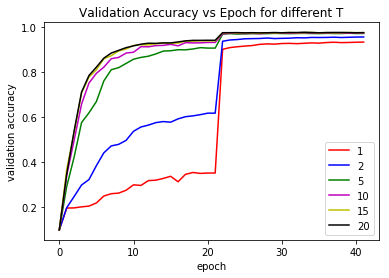

In [17]:
color = ['r', 'b', 'g', 'm', 'y', 'k']
for hparam, c in zip(hparams_list, color):
    cur_results = results_distill[utils.hparamDictToTuple(hparam)]
    val_acc = cur_results[0]['val_acc'] + cur_results[1]['val_acc']
    plt.plot(val_acc, color=c, label=str(hparam['T']))
    
plt.legend()
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('Validation Accuracy vs Epoch for different T')
plt.savefig(summaries_path_student + 'val_acc_vs_epoch_wrt_T.pdf')

In [ ]:
for hparam in hparams_list:
    load_path = checkpoints_path_student + utils.hparamToString(hparam) + '.tar'
    load_dict = torch.load(load_path)
    student_net = networks.StudentNetwork()
    student_net.load_state_dict(load_dict['model_state_dict'])
    student_net = student_net.to(fast_device)
    _, test_accuracy = utils.getLossAccuracyOnDataset(student_net, test_loader, fast_device)
    print(utils.hparamToString(hparam))
    print('test accuracy: ', test_accuracy)
    print('')

#### Effect of alpha

In [18]:
num_epochs = 20
num_epochs_bf = 20
print_every = 100

In [19]:
temperatures = [5]
# trade-off between soft-target (st) cross-entropy and true-target (tt) cross-entropy;
# loss = alpha * st + (1 - alpha) * tt
alphas = [0.8, 0.5, 0.4, 0.2]
learning_rates = [1e-2]
learning_rate_decays = [0.95]
weight_decays = [1e-5]
momentums = [0.9]
dropout_probabilities = [(0.0, 0.0)]
hparams_list = []
for hparam_tuple in itertools.product(alphas, temperatures, dropout_probabilities, weight_decays, learning_rate_decays, 
                                        momentums, learning_rates):
    hparam = {}
    hparam['alpha'] = hparam_tuple[0]
    hparam['T'] = hparam_tuple[1]
    hparam['dropout_input'] = hparam_tuple[2][0]
    hparam['dropout_hidden'] = hparam_tuple[2][1]
    hparam['weight_decay'] = hparam_tuple[3]
    hparam['lr_decay'] = hparam_tuple[4]
    hparam['momentum'] = hparam_tuple[5]
    hparam['lr'] = hparam_tuple[6]
    hparams_list.append(hparam)

results_distill = {}
for hparam in hparams_list:
    print('Training with hparams' + utils.hparamToString(hparam))
    reproducibilitySeed()
    student_net = networks.StudentNetwork()
    student_net = student_net.to(fast_device)
    hparam_tuple = utils.hparamDictToTuple(hparam)
    results_distill[hparam_tuple] = [None, None]
    results_distill[hparam_tuple][0] = utils.trainStudentOnHparam(teacher_net, student_net, hparam, num_epochs, 
                                                                    train_loader, val_loader, 
                                                                    print_every=print_every, 
                                                                    fast_device=fast_device)
    results_distill[hparam_tuple][1] = utils.trainStudentOnHparam(teacher_net, student_net, hparam, num_epochs_bf, 
                                                                    train_balanced_loader, val_loader, 
                                                                    print_every=print_every, 
                                                                    fast_device=fast_device, 
                                                                    only_penultimate_train=True)
    save_path = checkpoints_path_student + utils.hparamToString(hparam) + '.tar'
    torch.save({'results' : results_distill[hparam_tuple], 
                'model_state_dict' : student_net.state_dict(), 
                'epoch' : num_epochs}, save_path)


Training with hparamsT=5, alpha=0.8, dropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=1e-05
epoch: 0 validation accuracy: 0.100
[1,   100/  446] train loss: 1.107 train accuracy: 0.992
[1,   200/  446] train loss: 0.794 train accuracy: 1.000
[1,   300/  446] train loss: 0.741 train accuracy: 0.992
[1,   400/  446] train loss: 0.556 train accuracy: 1.000
epoch: 1 validation accuracy: 0.259
[2,   100/  446] train loss: 0.477 train accuracy: 1.000
[2,   200/  446] train loss: 0.469 train accuracy: 1.000
[2,   300/  446] train loss: 0.500 train accuracy: 0.992
[2,   400/  446] train loss: 0.411 train accuracy: 1.000
epoch: 2 validation accuracy: 0.345
[3,   100/  446] train loss: 0.383 train accuracy: 1.000
[3,   200/  446] train loss: 0.328 train accuracy: 1.000
[3,   300/  446] train loss: 0.318 train accuracy: 1.000
[3,   400/  446] train loss: 0.246 train accuracy: 1.000
epoch: 3 validation accuracy: 0.487
[4,   100/  446] train loss: 0.375 trai

[11,   200/  446] train loss: 0.531 train accuracy: 0.984
[11,   300/  446] train loss: 0.441 train accuracy: 0.992
[11,   400/  446] train loss: 0.554 train accuracy: 0.984
epoch: 11 validation accuracy: 0.971
[12,   100/  446] train loss: 0.506 train accuracy: 0.961
[12,   200/  446] train loss: 0.514 train accuracy: 0.977
[12,   300/  446] train loss: 0.552 train accuracy: 0.961
[12,   400/  446] train loss: 0.507 train accuracy: 0.984
epoch: 12 validation accuracy: 0.970
[13,   100/  446] train loss: 0.531 train accuracy: 0.953
[13,   200/  446] train loss: 0.579 train accuracy: 0.938
[13,   300/  446] train loss: 0.512 train accuracy: 0.984
[13,   400/  446] train loss: 0.584 train accuracy: 0.977
epoch: 13 validation accuracy: 0.971
[14,   100/  446] train loss: 0.660 train accuracy: 0.953
[14,   200/  446] train loss: 0.528 train accuracy: 0.977
[14,   300/  446] train loss: 0.632 train accuracy: 0.977
[14,   400/  446] train loss: 0.600 train accuracy: 0.977
epoch: 14 validatio

[1,   200/  446] train loss: 0.671 train accuracy: 0.961
[1,   300/  446] train loss: 0.656 train accuracy: 0.961
[1,   400/  446] train loss: 0.571 train accuracy: 0.945
epoch: 1 validation accuracy: 0.959
[2,   100/  446] train loss: 0.586 train accuracy: 0.945
[2,   200/  446] train loss: 0.503 train accuracy: 0.953
[2,   300/  446] train loss: 0.633 train accuracy: 0.930
[2,   400/  446] train loss: 0.558 train accuracy: 0.961
epoch: 2 validation accuracy: 0.965
[3,   100/  446] train loss: 0.635 train accuracy: 0.953
[3,   200/  446] train loss: 0.354 train accuracy: 0.992
[3,   300/  446] train loss: 0.530 train accuracy: 0.992
[3,   400/  446] train loss: 0.579 train accuracy: 0.930
epoch: 3 validation accuracy: 0.965
[4,   100/  446] train loss: 0.544 train accuracy: 0.969
[4,   200/  446] train loss: 0.468 train accuracy: 0.953
[4,   300/  446] train loss: 0.404 train accuracy: 0.961
[4,   400/  446] train loss: 0.587 train accuracy: 0.930
epoch: 4 validation accuracy: 0.968
[

[11,   300/  446] train loss: 0.100 train accuracy: 1.000
[11,   400/  446] train loss: 0.082 train accuracy: 1.000
epoch: 11 validation accuracy: 0.592
[12,   100/  446] train loss: 0.100 train accuracy: 1.000
[12,   200/  446] train loss: 0.080 train accuracy: 1.000
[12,   300/  446] train loss: 0.093 train accuracy: 1.000
[12,   400/  446] train loss: 0.098 train accuracy: 1.000
epoch: 12 validation accuracy: 0.633
[13,   100/  446] train loss: 0.095 train accuracy: 1.000
[13,   200/  446] train loss: 0.084 train accuracy: 1.000
[13,   300/  446] train loss: 0.098 train accuracy: 1.000
[13,   400/  446] train loss: 0.079 train accuracy: 1.000
epoch: 13 validation accuracy: 0.634
[14,   100/  446] train loss: 0.090 train accuracy: 1.000
[14,   200/  446] train loss: 0.089 train accuracy: 1.000
[14,   300/  446] train loss: 0.090 train accuracy: 0.992
[14,   400/  446] train loss: 0.065 train accuracy: 1.000
epoch: 14 validation accuracy: 0.660
[15,   100/  446] train loss: 0.082 trai

[1,   300/  446] train loss: 0.282 train accuracy: 0.992
[1,   400/  446] train loss: 0.220 train accuracy: 1.000
epoch: 1 validation accuracy: 0.198
[2,   100/  446] train loss: 0.197 train accuracy: 1.000
[2,   200/  446] train loss: 0.208 train accuracy: 1.000
[2,   300/  446] train loss: 0.222 train accuracy: 0.992
[2,   400/  446] train loss: 0.173 train accuracy: 1.000
epoch: 2 validation accuracy: 0.206
[3,   100/  446] train loss: 0.200 train accuracy: 1.000
[3,   200/  446] train loss: 0.158 train accuracy: 1.000
[3,   300/  446] train loss: 0.165 train accuracy: 1.000
[3,   400/  446] train loss: 0.150 train accuracy: 1.000
epoch: 3 validation accuracy: 0.222
[4,   100/  446] train loss: 0.168 train accuracy: 0.992
[4,   200/  446] train loss: 0.147 train accuracy: 1.000
[4,   300/  446] train loss: 0.146 train accuracy: 1.000
[4,   400/  446] train loss: 0.150 train accuracy: 1.000
epoch: 4 validation accuracy: 0.235
[5,   100/  446] train loss: 0.157 train accuracy: 0.992
[

[12,   200/  446] train loss: 0.311 train accuracy: 0.977
[12,   300/  446] train loss: 0.329 train accuracy: 0.977
[12,   400/  446] train loss: 0.273 train accuracy: 0.984
epoch: 12 validation accuracy: 0.955
[13,   100/  446] train loss: 0.372 train accuracy: 0.945
[13,   200/  446] train loss: 0.386 train accuracy: 0.922
[13,   300/  446] train loss: 0.295 train accuracy: 0.992
[13,   400/  446] train loss: 0.423 train accuracy: 0.938
epoch: 13 validation accuracy: 0.957
[14,   100/  446] train loss: 0.504 train accuracy: 0.930
[14,   200/  446] train loss: 0.396 train accuracy: 0.961
[14,   300/  446] train loss: 0.373 train accuracy: 0.945
[14,   400/  446] train loss: 0.365 train accuracy: 0.977
epoch: 14 validation accuracy: 0.956
[15,   100/  446] train loss: 0.477 train accuracy: 0.953
[15,   200/  446] train loss: 0.306 train accuracy: 0.969
[15,   300/  446] train loss: 0.274 train accuracy: 0.977
[15,   400/  446] train loss: 0.283 train accuracy: 0.977
epoch: 15 validatio

In [ ]:
# plt.rcParams['figure.figsize'] = [10, 5]
T_scatter = [math.log(h['T']) for h in hparams_list]
alpha_scatter = [h['alpha'] for h in hparams_list]
colors = []
for i in range(len(hparams_list)):
    cur_hparam_tuple = utils.hparamDictToTuple(hparams_list[i])
    colors.append(results_distill[cur_hparam_tuple]['val_acc'][-1])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(T_scatter, alpha_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(T_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (T_scatter[i], alpha_scatter[i]))
plt.show()

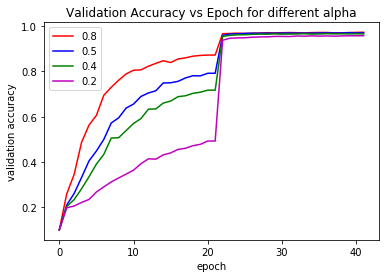

In [21]:
color = ['r', 'b', 'g', 'm']
for hparam, c in zip(hparams_list, color):
    cur_results = results_distill[utils.hparamDictToTuple(hparam)]
    val_acc = cur_results[0]['val_acc'] + cur_results[1]['val_acc']
    plt.plot(val_acc, color=c, label=str(hparam['alpha']))
    
plt.legend()
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('Validation Accuracy vs Epoch for different alpha')
plt.savefig(summaries_path_student + 'val_acc_vs_epoch_wrt_alpha.pdf')

In [22]:
for hparam in hparams_list:
    load_path = checkpoints_path_student + utils.hparamToString(hparam) + '.tar'
    load_dict = torch.load(load_path)
    student_net = networks.StudentNetwork()
    student_net.load_state_dict(load_dict['model_state_dict'])
    student_net = student_net.to(fast_device)
    _, test_accuracy = utils.getLossAccuracyOnDataset(student_net, test_loader, fast_device)
    print(utils.hparamToString(hparam))
    print('test accuracy: ', test_accuracy)
    print('')

T=5, alpha=0.8, dropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=1e-05
test accuracy:  0.9745

T=5, alpha=0.5, dropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=1e-05
test accuracy:  0.9725

T=5, alpha=0.4, dropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=1e-05
test accuracy:  0.9708

T=5, alpha=0.2, dropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=1e-05
test accuracy:  0.9633

